In [160]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from collections import namedtuple
from IPython.display import clear_output
from tqdm.notebook import tqdm

from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXGate, RYGate, RZGate, CXGate, CZGate, IGate
from qiskit_aer import AerSimulator

In [86]:
np.set_printoptions(precision=3, floatmode='fixed')

In [3]:
GATESET = [
    (RXGate, True),
    (RYGate, True),
    (RZGate, True),
    (CZGate, False),
]

In [4]:
class Unit:
    
    def __init__(self, gates, params, qubits, num_param):
        self.gates = gates
        self.params = params
        self.qubits = qubits
        self.num_param = num_param
        self._values = None
    
    @classmethod
    def generate_random(cls, nq, ng, prefix=None, policy="zero"):
        gates = []
        params = []
        qubits = []
        num_param = 0
        
        selected_gates = [
            GATESET[i]
            for i in np.random.choice(np.arange(len(GATESET)), replace=True, size=ng)
        ]
        for gate, istrainable in selected_gates:
            qt = np.random.randint(nq)
            
            if not istrainable:
                gates.append(gate())
                params.append(None)
                qubits.append((qt, (qt + 1) % nq))
                continue

            pname = f"param_{len(params)}"
            if prefix is not None:
                pname = prefix + "_" + pname
            param = Parameter(pname)

            gates.append(gate(param))
            params.append(param)
            qubits.append(qt)
            num_param += 1
        
        unit = cls(gates, params, qubits, num_param)
        if policy is None:
            return unit
        
        if policy == "randomn":
            values = np.random.rand(num_param) * 2 * np.pi
        elif policy == "zero":
            values = np.zeros(num_param)

        unit.set_values(values)
        
        return unit

    def feed_dict(self, values=None):
        if values is None:
            values = self.values
        if not hasattr(values, "__len__"):
            values = [values]
        iter_values = iter(values)
        return {
            param.name: next(iter_values)
            for param in self.params if param is not None
        }
    
    def apply_to_circuit(self, qc):
        for gate, qubit in zip(self.gates, self.qubits):
            if isinstance(gate, CZGate):
                qargs = [
                    qc.qubits[qubit[0]],
                    qc.qubits[qubit[1]]
                ]
            else:
                qargs = [qc.qubits[qubit]]
            qc.append(gate, qargs=qargs)
        qc.barrier()
        return qc
    
    def set_values(self, values):
        values = np.asarray(values)
        values = values % (2 * np.pi)
        self._values = values
        return self
    
    @property
    def values(self):
        return np.asarray(self._values).copy()


In [5]:
class InputUnit(Unit):
    
    @classmethod
    def generate_rxs(cls, nq):
        params = [Parameter("unit_i_param_0")]
        gates = [RXGate(params[0]) for _ in range(nq)]
        qubits = np.arange(nq)
        num_param = 1
        return cls(gates, params, qubits, num_param)

{'unit_i_param_0': 1, 'unit_0_param_0': np.float64(0.0), 'unit_0_param_2': np.float64(0.0), 'unit_0_param_3': np.float64(0.0)}


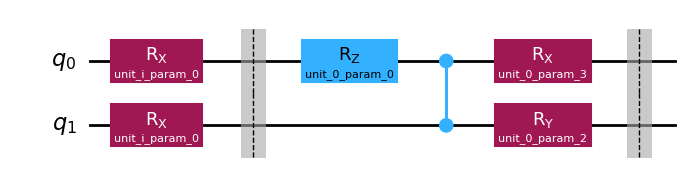

In [48]:
qc = QuantumCircuit(2)

iunit = InputUnit.generate_rxs(2)
unit = Unit.generate_random(2, 4, prefix="unit_0")

x = 1
params = np.zeros(unit.num_param)

feed_dict = iunit.feed_dict(x) | unit.feed_dict(params)
print(feed_dict)

iunit.apply_to_circuit(qc)
unit.apply_to_circuit(qc)
qc.draw("mpl")

In [51]:
class Model:
    
    def __init__(self, num_qubit, num_output, input_units, fixed_units, trainable_unit, shots=100, sim=None):
        self.nq = num_qubit
        self.nc = num_output
        self.input_units = input_units
        self.fixed_units = fixed_units
        self.trainable_unit = trainable_unit
        self.sim = sim if sim is not None else AerSimulator()
        self.shots = shots
    
    def forward(self, x, params=None, shots=None):
        if params is None:
            params = self.trainable_unit.values
        if shots is None:
            shots = self.shots
        qc = self.apply_units()
        feed_dict = self.input_units.feed_dict(x)
        for unit in zip(self.fixed_units):
            feed_dict |= unit.feed_dict()
        feed_dict |= self.trainable_unit.feed_dict(params)
        
        # print("feed_dict:", feed_dict)
        
        bc = qc.assign_parameters(feed_dict)
        job = transpile(bc, self.sim)
        res = self.sim.run(job, shots=shots).result().get_counts()
        pre = res.get("0", 0) - res.get("1", 0)
        return pre / shots
    
    def apply_units(self):
        qc = QuantumCircuit(self.nq, self.nc)
        
        self.input_units.apply_to_circuit(qc)
        [
            fixed_unit.apply_to_circuit(qc)
            for fixed_unit in self.fixed_units
        ]
        self.trainable_unit.apply_to_circuit(qc)
        
        qc.measure(0, 0)
        return qc

In [95]:
model = Model(2, 1, InputUnit.generate_rxs(2), [], Unit.generate_random(2, 3, prefix="unit_0"))

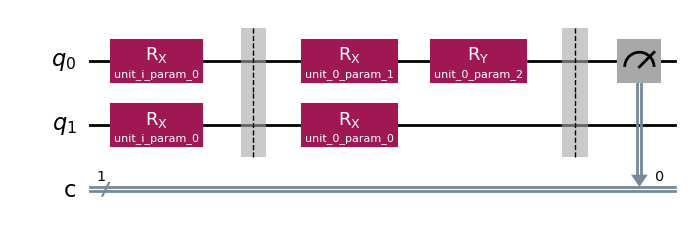

In [96]:
qc = model.apply_units()
qc.draw("mpl")

In [125]:
def calc_gradients(model, x, shots=100):
    trainable_params = model.trainable_unit.values

    def calc_gradient_i(idx):
        shifted_pos = trainable_params.copy()
        shifted_neg = trainable_params.copy()
        shifted_pos[idx] = (trainable_params[idx] + np.pi / 2) % (np.pi * 2)
        shifted_neg[idx] = (trainable_params[idx] - np.pi / 2) % (np.pi * 2)
        
        predict_pos = model.forward(x, params=shifted_pos, shots=shots)
        predict_neg = model.forward(x, params=shifted_neg, shots=shots)
        grad = (predict_pos - predict_neg) / 2
        return grad
    
    grads = np.asarray([
        calc_gradient_i(idx)
        for idx in range(len(trainable_params))
    ])
    return grads

$$
\begin{eqnarray}
\mathcal{L}(\theta) &=& \underset{x_i \sim \mathcal{B}}{\mathbb{E}} \left[ \frac{1}{2} \left(f(x_i) - \phi(x_i, \theta) \right)^T \cdot \left(f(x_i) - \phi(x_i, \theta) \right) \right] \\
\nabla_\theta \mathcal{L}(\theta) &=& \underset{x_i \sim \mathcal{B}}{\mathbb{E}} \left[ - w \left(f(x_i) - \phi(x_i, \theta) \right)^T \cdot \frac{\left< B \right>_i^+ - \left< B \right>_i^- }{2} \right]
\end{eqnarray}
$$

In [104]:
fn = lambda x: np.sin(x * 2 * np.pi)

In [121]:
loss_func = lambda ys, ps: np.mean(np.square(ys - ps)) * 0.5

In [107]:
xs = np.arange(11) / 10
ys = fn(xs)

In [130]:
lr = 0.01

In [115]:
params = model.trainable_unit.values

In [140]:
def calc_batch_grads(model, xs):
    grads = np.asarray([
        calc_gradients(model, x, shots=50) * e
        for x, e in zip(xs, es)
    ])
    return grads

In [163]:
def training_step(model, xs, ys, lr=0.01, shots=100):
    params = model.trainable_unit.values
    ps = np.array([model.forward(x, params=params, shots=shots) for x in xs])
    es = ys - ps
    es = np.expand_dims(es, axis=1)
    loss = loss_func(ys, ps)
    grads = calc_batch_grads(model, xs)
    dparams = (es * grads).mean(axis=0)
    params = params - lr * dparams
    return params, loss

In [164]:
model = Model(2, 1, InputUnit.generate_rxs(2), [], Unit.generate_random(2, 3, prefix="unit_0"))

In [166]:
log = dict(
    loss=[],
    time=[],
)
for step in range(1, 51):
    time_avans = time.time()
    params, loss = training_step(model, xs, ys, lr=0.1, shots=50)
    model.trainable_unit.set_values(params)
    time_apres = time.time()
    time_calc = time_apres - time_avans
    log["loss"].append(loss)
    log["time"].append(time_calc)
    print(f"Step: {step: 3}, Loss: {loss:6.3f}, Time: {time_calc:6.3f}")

Step:   1, Loss:  0.476, Time:  1.397
Step:   2, Loss:  0.437, Time:  1.060
Step:   3, Loss:  0.436, Time:  1.124
Step:   4, Loss:  0.408, Time:  1.125
Step:   5, Loss:  0.425, Time:  1.055
Step:   6, Loss:  0.380, Time:  1.051
Step:   7, Loss:  0.411, Time:  1.054
Step:   8, Loss:  0.338, Time:  1.049
Step:   9, Loss:  0.386, Time:  1.044
Step:  10, Loss:  0.336, Time:  1.102
Step:  11, Loss:  0.346, Time:  1.041
Step:  12, Loss:  0.329, Time:  1.041
Step:  13, Loss:  0.298, Time:  1.043
Step:  14, Loss:  0.278, Time:  1.045
Step:  15, Loss:  0.316, Time:  1.045
Step:  16, Loss:  0.291, Time:  1.043
Step:  17, Loss:  0.294, Time:  1.119
Step:  18, Loss:  0.264, Time:  1.046
Step:  19, Loss:  0.234, Time:  1.042
Step:  20, Loss:  0.257, Time:  1.042
Step:  21, Loss:  0.296, Time:  1.044
Step:  22, Loss:  0.263, Time:  1.046
Step:  23, Loss:  0.223, Time:  1.105
Step:  24, Loss:  0.238, Time:  1.042
Step:  25, Loss:  0.223, Time:  1.044
Step:  26, Loss:  0.267, Time:  1.041
Step:  27, L

(0.0, 50.0)

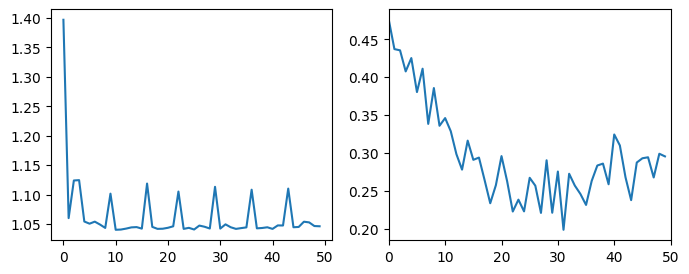

In [171]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
axes[0].plot(log["time"])
axes[1].plot(log["loss"])
plt.xlim([0, 50])

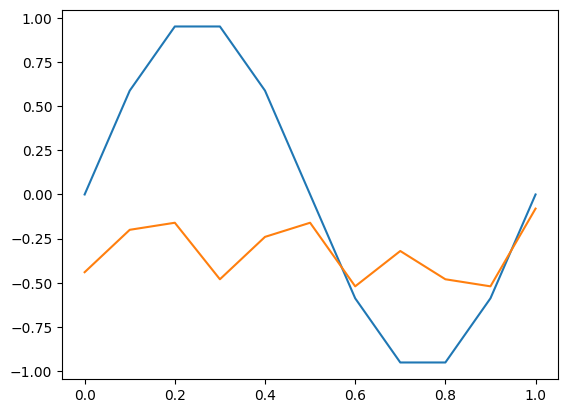

In [174]:
ps = [model.forward(x, shots=50) for x in xs]
fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.plot(xs, ps)

In [129]:
grads = np.asarray([
    calc_gradients(model, x, shots=50) * e
    for x, e in zip(xs, es)
]).mean(axis=0)
grads, params

(array([-0.001,  0.423,  0.017]), array([0.000, 0.000, 0.000]))